In [ ]:
# connect to google drive
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH, force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/ProgettoAI/ProgettoAI/SteRoom

/content/gdrive/.shortcut-targets-by-id/1MJ_PV3yImcP5lKaIH7f9wKK1soWaIlGT/ProgettoAI/ProgettoAI/SteRoom


### Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import random
from PIL import Image
import warnings
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from skimage.color import rgb2gray
from tensorflow.keras.optimizers import Adam

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.9.2


### Seed

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

### Loading Image Dataset

In [ ]:
data_dir = '/content/gdrive/MyDrive/ProgettoAI/ProgettoAI/Processed_dataset'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# Input Parameters
img_w = 256
img_h = 256
classes = 3
batch_size = 32

In [ ]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

training_set = datagen.flow_from_directory(
        directory = training_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

validation_set = datagen.flow_from_directory(
        directory = validation_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


### Load EfficientNet supernet

In [ ]:
input_shape = (img_h, img_w, 3)

In [ ]:
#Download net
supernet = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(input_shape)
)

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
#Classifier
supernet.trainable = False

inputs = tfk.Input(shape=input_shape)
x = supernet(inputs) #one layer is supernet
x = tfkl.GlobalAveragePooling2D(name = 'gap')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    128, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    3, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 gap (GlobalAveragePooling2D  (None, 1536)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [ ]:
# Callbacks

# Early Stopping 
earlystopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)

# Learning Rate 
learningrate = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.1, min_lr=1e-8)

callbacks_list = [earlystopping, learningrate]

In [ ]:
# Train the model
history = tl_model.fit(
    x = training_set,
    epochs = 200,
    validation_data = validation_set,
    callbacks = callbacks_list
).history

Epoch 1/200
339/339 [==============================] - 2946s 9s/step - loss: 0.4355 - accuracy: 0.8239 - val_loss: 0.2413 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 2/200
339/339 [==============================] - 64s 189ms/step - loss: 0.3077 - accuracy: 0.8776 - val_loss: 0.2498 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 3/200
339/339 [==============================] - 64s 189ms/step - loss: 0.2898 - accuracy: 0.8895 - val_loss: 0.2100 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 4/200
339/339 [==============================] - 64s 189ms/step - loss: 0.2672 - accuracy: 0.8986 - val_loss: 0.2137 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 5/200
339/339 [==============================] - 64s 189ms/step - loss: 0.2508 - accuracy: 0.9069 - val_loss: 0.1988 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 6/200
339/339 [==============================] - 64s 189ms/step - loss: 0.2379 - accuracy: 0.9065 - val_loss: 0.2023 - val_accuracy: 0.9248 - lr: 0.0010
Epoch 7/200
339/339 [==========================

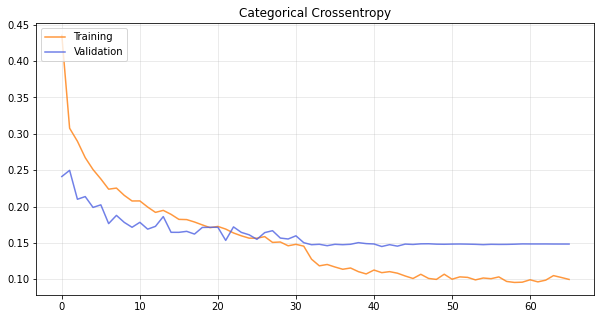

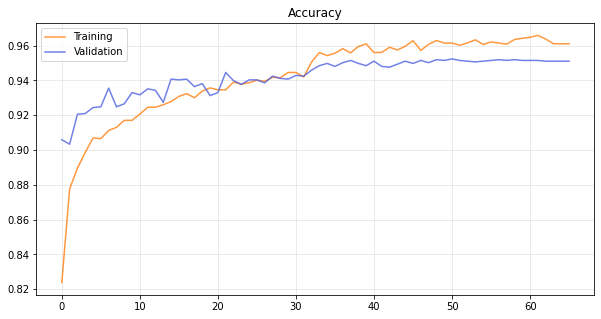

In [ ]:
# Plot the training

# Loss Function
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

In [ ]:
[test_loss, test_accuracy] = tl_model.evaluate(test_set)

73/73 [==============================] - 719s 10s/step - loss: 0.1875 - accuracy: 0.9233


In [ ]:
labels = ['N', 'P', 'T']

Accuracy: 0.463
Precision: 0.339
Recall: 0.3387
F1: 0.3386


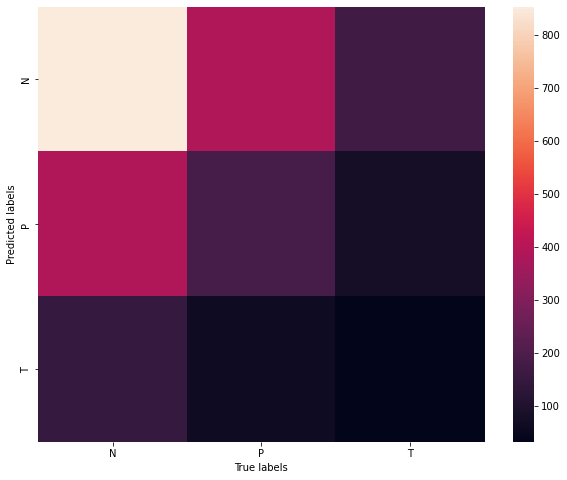

In [ ]:
#Confusion matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_set)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix

cm = (confusion_matrix(test_set.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_set.classes, predicted_classes)
precision = precision_score(test_set.classes, predicted_classes, average='macro')
recall = recall_score(test_set.classes, predicted_classes, average='macro')
f1 = f1_score(test_set.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits = 4))

In [ ]:
#cf on validation for comparisons
val_predictions = tl_model.predict(validation_set)

73/73 [==============================] - 12s 142ms/step


In [ ]:
y_val = validation_set.labels

              precision    recall  f1-score   support

           0     0.9525    0.9739    0.9631      1420
           1     0.9688    0.9795    0.9742       635
           2     0.9056    0.7757    0.8356       272

    accuracy                         0.9523      2327
   macro avg     0.9423    0.9097    0.9243      2327
weighted avg     0.9515    0.9523    0.9512      2327



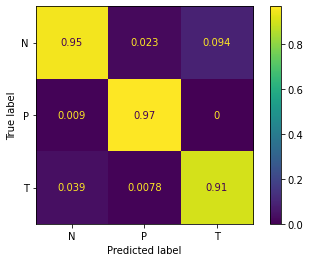

In [ ]:
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

In [ ]:
test_predictions = tl_model.predict(test_set)

73/73 [==============================] - 487s 7s/step


In [ ]:
y_test = test_set.labels

              precision    recall  f1-score   support

           0     0.9420    0.9677    0.9546      1392
           1     0.9593    0.9669    0.9631       634
           2     0.9125    0.7739    0.8375       283

    accuracy                         0.9437      2309
   macro avg     0.9379    0.9028    0.9184      2309
weighted avg     0.9431    0.9437    0.9426      2309



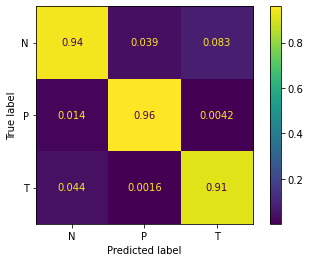

In [ ]:
print_evaluation(y_test, np.argmax(test_predictions, axis=-1))

### Save Model

In [ ]:
tl_model.save('effB3_frozen')